In [1]:
import numpy as np
import scipy.linalg as LA
from scipy.integrate import solve_ivp, cumtrapz, trapz
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import multiprocessing as mp

from mpl_toolkits.mplot3d import Axes3D
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline
mpl.rcParams.update({'font.size': 14})

In [2]:
class Rocket2:
    
    def __init__(self, T, m0=1000, M=100, l=500, u_max=100, k=1e-3, g=10, alpha=1, H=1000):
        self.T = T
        self.m0 = m0
        self.M = M
        self.l = l
        self.u_max = u_max
        self.k = k
        self.g = g
        self.alpha = alpha
        self.H = H
        
        self.extremals_regular = []
        self.extremals_special = []
        
    def odefunc(self, t, y, u, direction):
        
        # направление силы сопротивления воздуха
        if y[0] > 0:
            s = 1
        else:
            s = -1
        
        if callable(u):
            u = u(t, y)
        
        dx1 = -self.g - s * self.k * y[0]**2 / y[1] + u / y[1] * (self.l + y[0])
        dx2 = -u
        dpsi1 = -1 - y[2] * (u - 2 * s * self.k * y[0]) / y[1]
        dpsi2 = (-s * self.k * y[0]**2 + u * (self.l + y[0])) * y[2] / y[1]**2
        
        return direction * np.array([dx1, dx2, dpsi1, dpsi2])
    
    def F(self, t, y):
        return -y[1] * np.exp(-self.alpha * t) + y[2] * (y[0] + self.l) - y[3] * y[1]
    
    def switch_to_max_event(self, t, y, dummy1=None, dummy2=None):
        return self.F(t, y)
    switch_to_max_event.terminal = True
    switch_to_max_event.direction = -1
    
    def switch_to_zero_event(self, t, y, dummy1=None, dummy2=None):
        return self.F(t, y)
    switch_to_zero_event.terminal = True
    switch_to_zero_event.direction = 1
    
    def fuel_zero_event(self, t, y, dummy1=None, dummy2=None):
        return y[1] - self.M
    fuel_zero_event.terminal = True
    
    def fuel_full_event(self, t, y, dummy1=None, dummy2=None):
        return y[1] - self.m0
    fuel_full_event.terminal = True
    
    def special_mode(self, t, y):
        
        u = self.alpha**2 * y[1]**3 * np.exp(-self.alpha * t)
        u += 2 * self.g * self.k * self.l * y[2] * y[1]
        u += 6 * self.g * self.k * y[0] * y[1] * y[2]
        u -= 2 * self.g * y[1]**2
        u -= 2 * self.k**2 * self.l * y[2] * y[0]**2
        u += 2 * self.k * self.l * y[0] * y[1]
        u += self.k * y[0]**2 * y[1]
        
        denom = -self.alpha * y[1]**2 * np.exp(-self.alpha * t)
        denom += self.g * y[2] * y[1]
        denom += 2 * self.k * self.l**2 * y[2]
        denom += 6 * self.k * self.l * y[2] * y[0]
        denom += 4 * self.k * y[2] * y[0]**2
        denom -= y[1] * (self.l + y[0])
        
        return u / denom
    
    def ivp_wrapper(self, y0, max_step=np.inf):
        
        tau = 0
        cur_u = self.u_max
        
        m = np.empty(0)
        v = np.empty(0)
        psi = np.empty((2, 0))
        u = np.empty(0)
        t = np.empty(0)
        
        success = True
        niter = 0
        
        while tau < self.T:
            
            if cur_u > 0:
                switch = self.switch_to_zero_event
            else:
                switch = self.switch_to_max_event
            
            sol = solve_ivp(
                fun=self.odefunc,
                t_span=(tau, self.T),
                y0=y0,
                method='RK45',
                args=(cur_u, 1),
                events=(switch, self.fuel_zero_event),
                max_step=max_step
            )
            
            t = np.hstack((t, sol.t))
            v = np.hstack((v, sol.y[0]))
            m = np.hstack((m, sol.y[1]))
            psi = np.hstack((psi, sol.y[2:]))
            u = np.hstack((u, np.full_like(sol.t, cur_u)))
            
            # если сломалось интегрирование, заканчиваем 
            if sol.status < 0 or niter > 15:
                success = False
                break
            
            # если не было event'ов, заканчиваем
            if sol.status == 0:
                break
                
            # если потратили все топливо, то тупо заканчиваем
            if sol.t_events[1].size > 0:
                sol = solve_ivp(
                    fun=self.odefunc,
                    t_span=(sol.t_events[1][0], self.T),
                    y0=sol.y_events[1][0],
                    method='RK45',
                    args=(0, 1),
                    max_step=max_step
                )
                
                t = np.hstack((t, sol.t))
                v = np.hstack((v, sol.y[0]))
                m = np.hstack((m, sol.y[1]))
                psi = np.hstack((psi, sol.y[2:]))
                u = np.hstack((u, np.zeros_like(sol.t)))
                
                break
            
            # если произошло переключение, обновляем начальное условие и переключаемся
            cur_u = self.u_max - cur_u
            y0 = sol.y[:, -1]
            tau = sol.t[-1]
            
            niter += 1
        
        return (success, {
            't': t,
            'v': v,
            'h': cumtrapz(v, t, initial=0),
            'm': m,
            'psi': psi,
            'u': u
        })
        
    def spec_ivp_wrapper(self, y0, max_step=np.inf):
        
        tau = 0
        cur_u = self.u_max
        
        m = np.empty(0)
        v = np.empty(0)
        psi = np.empty((2, 0))
        u = np.empty(0)
        t = np.empty(0)
        
        success = True
        
        sol = solve_ivp(
            fun=self.odefunc,
            t_span=(tau, self.T),
            y0=y0,
            method='RK45',
            args=(cur_u, 1),
            events=(self.switch_to_zero_event, self.fuel_zero_event),
            max_step=max_step
        )
        
        t = np.hstack((t, sol.t))
        v = np.hstack((v, sol.y[0]))
        m = np.hstack((m, sol.y[1]))
        psi = np.hstack((psi, sol.y[2:]))
        u = np.hstack((u, np.full_like(sol.t, cur_u)))
        
        # если сломалось интегрирование, заканчиваем 
        if sol.status < 0:
            return (False, {
                't': t,
                'v': v,
                'h': cumtrapz(v, t, initial=0),
                'm': m,
                'psi': psi,
                'u': u
            })
        
        # если не было event'ов, заканчиваем
        if sol.status == 0:
            return (True, {
                't': t,
                'v': v,
                'h': cumtrapz(v, t, initial=0),
                'm': m,
                'psi': psi,
                'u': u
            })
            
        # если потратили все топливо, то тупо заканчиваем
        if sol.t_events[1].size > 0:
            sol = solve_ivp(
                fun=self.odefunc,
                t_span=(sol.t_events[1][0], self.T),
                y0=sol.y_events[1][0],
                method='RK45',
                args=(0, 1),
                max_step=max_step
            )
            
            t = np.hstack((t, sol.t))
            v = np.hstack((v, sol.y[0]))
            m = np.hstack((m, sol.y[1]))
            psi = np.hstack((psi, sol.y[2:]))
            u = np.hstack((u, np.zeros_like(sol.t)))
            
            return (sol.status >= 0, {
                't': t,
                'v': v,
                'h': cumtrapz(v, t, initial=0),
                'm': m,
                'psi': psi,
                'u': u
            })
        
        # если триггернулся event на переключение, то залетаем в особый режим
        y0 = sol.y[:, -1]
        tau = sol.t[-1]
        
        sol = solve_ivp(
            fun=self.odefunc,
            t_span=(tau, self.T),
            y0=y0,
            method='RK45',
            args=(self.special_mode, 1),
            max_step=max_step,
            events=self.fuel_zero_event
        )
        
        t = np.hstack((t, sol.t))
        v = np.hstack((v, sol.y[0]))
        m = np.hstack((m, sol.y[1]))
        psi = np.hstack((psi, sol.y[2:]))
        u = np.hstack((u, self.special_mode(sol.t, sol.y)))
        
        # если сломалось интегрирование, так и говорим
        if sol.status < 0:
            return (False, {
            't': t,
            'v': v,
            'h': cumtrapz(v, t, initial=0),
            'm': m,
            'psi': psi,
            'u': u
        })
        
        # если закончилось топливо, дотягиваем траекторию
        if sol.status == 1:
            sol = solve_ivp(
                fun=self.odefunc,
                t_span=(sol.t[-1], self.T),
                y0=sol.y[:, -1],
                method='RK45',
                args=(0, 1),
                max_step=max_step
            )
        
            t = np.hstack((t, sol.t))
            v = np.hstack((v, sol.y[0]))
            m = np.hstack((m, sol.y[1]))
            psi = np.hstack((psi, sol.y[2:]))
            u = np.hstack((u, np.zeros_like(sol.t)))
        
        success = sol.status >= 0
        
        return (success, {
            't': t,
            'v': v,
            'h': cumtrapz(v, t, initial=0),
            'm': m,
            'psi': psi,
            'u': u
        })
    
    def solve_stupid(self, ngrid=100, psi_bnd=(-50, 50)):
        
        psi1_init_list = np.linspace(psi_bnd[0], psi_bnd[1], ngrid)
        psi2_init_list = np.linspace(psi_bnd[0], psi_bnd[1], ngrid)
        
        for psi1_init in tqdm(psi1_init_list):
            for psi2_init in psi2_init_list:
                
                success, sol = self.ivp_wrapper(np.array([0, self.m0, psi1_init, psi2_init]), np.inf)
                
                if not success:
                    continue
                
                # если все хорошо, то добавляем в список экстремальных
                self.extremals_regular.append(sol)
            
        for psi1_init in tqdm(psi1_init_list):
            for psi2_init in psi2_init_list:
                
                success, sol = self.spec_ivp_wrapper(np.array([0, self.m0, psi1_init, psi2_init]), np.inf)
                
                if not success:
                    continue
                
                # если все хорошо, то добавляем в список экстремальных
                self.extremals_special.append(sol)
        
        # среди экстремальных выбираем оптимальное, если есть
        if len(self.extremals_regular) == 0 and len(self.extremals_special) == 0:
            print('No solutions were found')
            return self

        if len(self.extremals_regular) > 0:
            final_heights_regular = np.array([it['h'][-1] for it in self.extremals_regular])
            idx_reg = np.argmin(np.abs(final_heights_regular - self.H))
            s = self.extremals_regular[idx_reg]
            _, self.sol_regular = self.ivp_wrapper(
                np.array([0, self.m0, s['psi'][0][0], s['psi'][1][0]]), 0.1)
        
        if len(self.extremals_special) > 0:
            final_heights_special = np.array([it['h'][-1] for it in self.extremals_special])
            idx_spec = np.argmin(np.abs(final_heights_special - self.H))
            s = self.extremals_special[idx_spec]
            _, self.sol_special = self.spec_ivp_wrapper(
                np.array([0, self.m0, s['psi'][0][0], s['psi'][1][0]]), 0.1)
        
        print('Solved')
        return self
    
    def plot_solution(self, sol='o', axes=None):
        
        J_spec = trapz(np.exp(-self.alpha * self.sol_special['t'] * self.sol_special['u']),
                       self.sol_special['t'])
        J_reg = trapz(np.exp(-self.alpha * self.sol_regular['t'] * self.sol_regular['u']),
                      self.sol_regular['t'])
        
        if sol == 'o':
            if J_spec < J_reg:
                sol = self.sol_special
                J = J_spec
            else:
                sol = self.sol_regular
                J = J_reg
        elif sol == 'r':
            sol = self.sol_regular
            J = J_reg
        elif sol == 's':
            sol = self.sol_special
            J = J_spec
            
        if axes is None:
            fig, axes = plt.subplots(3, 2, figsize=(12, 15))
        
        axes[0][0].plot(sol['t'], sol['h'])
        axes[0][0].set_xlabel('время')
        axes[0][0].set_ylabel('высота')
        axes[0][0].set_title('Высота ракеты')
        
        axes[0][1].plot(sol['t'], sol['v'])
        axes[0][1].set_xlabel('время')
        axes[0][1].set_ylabel('скорость')
        axes[0][1].set_title('Скорость ракеты')
        
        axes[1][0].plot(sol['t'], sol['m'])
        axes[1][0].set_xlabel('время')
        axes[1][0].set_ylabel('масса')
        axes[1][0].set_title('Масса ракеты')
        
        axes[1][1].plot(sol['t'], sol['u'])
        axes[1][1].set_xlabel('время')
        axes[1][1].set_ylabel('управление')
        axes[1][1].set_title('Оптимальное управление')
        
        axes[2][0].plot(sol['t'], sol['psi'][0])
        axes[2][0].set_xlabel('время')
        axes[2][0].set_ylabel('$\psi_1$')
        axes[2][0].set_title('Споряженная переменная для скорости')
        
        axes[2][1].plot(sol['t'], sol['psi'][1])
        axes[2][1].set_xlabel('время')
        axes[2][1].set_ylabel('$\psi_2$')
        axes[2][1].set_title('Споряженная переменная для массы')
        
        fig.tight_layout()
        
        print('Значение функционала: {}'.format(J))
        
        return fig
    
    def set_params(self, **kwargs):
        self.__dict__.update(kwargs)
        return self
    
    def get_params(self):
        return self.__dict__

In [11]:
problem = Rocket2(T=15, k=1, alpha=1e-3)
problem.solve_stupid(100, (60, 100));

100%|██████████| 100/100 [01:27<00:00,  1.14it/s]

Solved


Значение функционала: 14.280350516977618


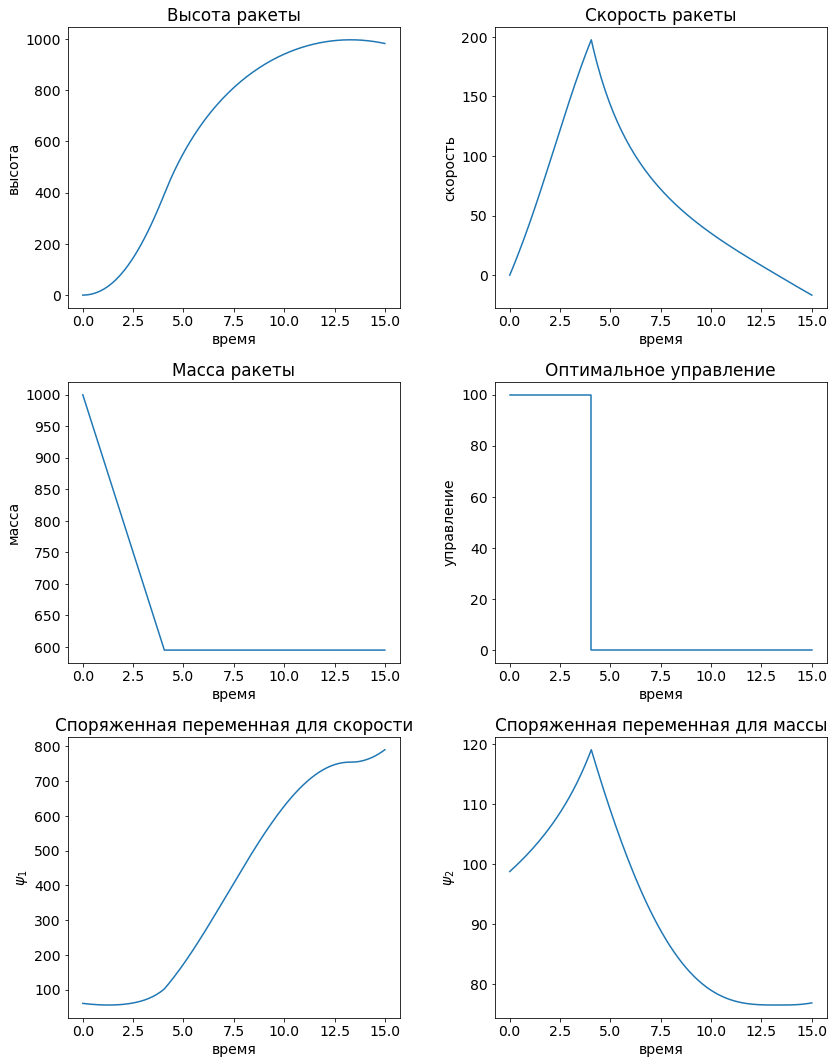

In [13]:
fig = problem.plot_solution('r')

In [37]:
fig.savefig('2_3.pdf', bbox_inces='tight')